In [1]:
from os import path

import astropy.coordinates as coord
from astropy.table import Table
import astropy.units as u
from astropy.io import ascii
from astropy.io import fits
from astropy.wcs import WCS
import reproject

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from scipy.spatial import cKDTree, ConvexHull

from pyia import GaiaData
import gala.dynamics as gd
import gala.coordinates as gc
import gala.potential as gp
from gala.mpl_style import center_emph, center_deemph

Using same values from Patel et al.

In [2]:
vsun = coord.CartesianDifferential([11.1, 251.24, 7.25]*u.km/u.s)
gc_frame = coord.Galactocentric(galcen_distance=8.1*u.kpc, galcen_v_sun=vsun)

Convert gas velocity from LSR back to Barycentric:

In [4]:
_gal = coord.SkyCoord(ra=179*u.deg, dec=-29*u.deg).galactic
l = _gal.l
b = _gal.b

vlsr = 90. * u.km/u.s
vbsr = vlsr - (9*u.km/u.s * np.cos(l)*np.cos(b) + 
               12*u.km/u.s * np.sin(l)*np.cos(b) +
               7*u.km/u.s * np.sin(b))

In [5]:
c = coord.SkyCoord(ra=179*u.deg, dec=-29*u.deg, 
                   distance=29*u.kpc,
                   pm_ra_cosdec=-0.56*u.mas/u.yr, 
                   pm_dec=0.47*u.mas/u.yr,
                   radial_velocity=vbsr)

In [6]:
galcen = c.transform_to(coord.Galactocentric)
galcen.velocity.norm(), galcen.velocity.d_z

(<Quantity 186.1039819452739 km / s>, <Quantity 93.85771163228321 km / s>)

In [7]:
galcen.represent_as(coord.CylindricalRepresentation)

<CylindricalRepresentation (rho, phi, z) in (kpc, rad, kpc)
    ( 23.23399553, -1.58982638,  15.50702888)
 (has differentials w.r.t.: 's')>

In [10]:
pot = gp.MilkyWayPotential()

cl_w0 = gd.PhaseSpacePosition(galcen.cartesian)
lmc_w0 = gd.PhaseSpacePosition(pos=[-1.1, -41.1, -27.9] * u.kpc,
                               vel=[-57., -226, 221] * u.km/u.s)

In [27]:
cl_orbit = pot.integrate_orbit(cl_w0, dt=-1, n_steps=3000)
lmc_orbit = pot.integrate_orbit(lmc_w0, dt=-1, n_steps=300)
lmc_orbit_fut = pot.integrate_orbit(lmc_w0, dt=1, n_steps=300)

In [28]:
cyl = cl_orbit.represent_as(coord.CylindricalRepresentation)
lmc_cyl = lmc_w0.represent_as(coord.CylindricalRepresentation)
lmc_fut_cyl = lmc_orbit_fut.represent_as(coord.CylindricalRepresentation)

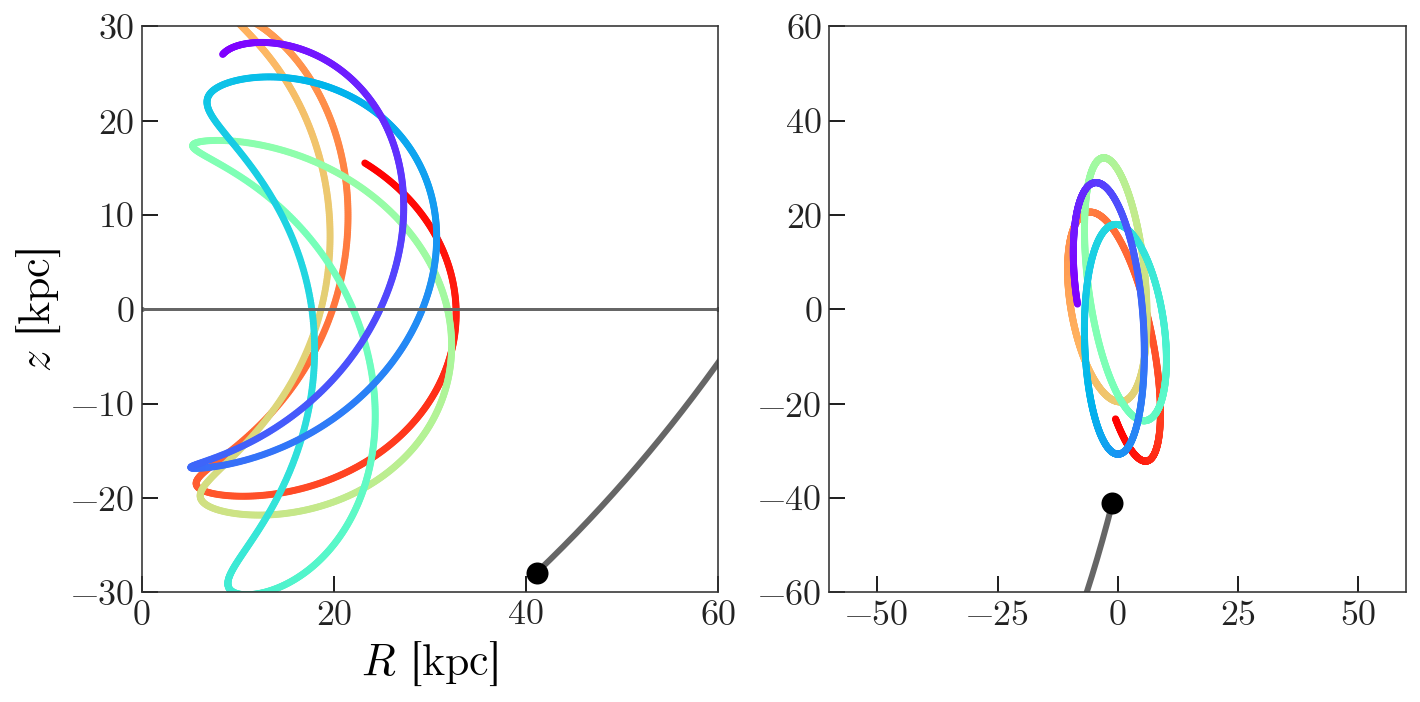

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
_cs = ax.scatter(cyl.rho, cyl.z, 
                 c=cl_orbit.t.value, marker='.',
                 cmap='rainbow')

ax.scatter(lmc_cyl.rho, lmc_cyl.z, 
           marker='o', color='k', 
           s=100, zorder=100)
    
ax.plot(lmc_fut_cyl.rho, lmc_fut_cyl.z,
        ls='-', marker='', color='#666666', 
        zorder=-100, lw=3)
    
ax.set_xlim(0, 60)
ax.set_ylim(-30, 30)

ax.axhline(0)

ax.set_xlabel('$R$ [kpc]')
ax.set_ylabel('$z$ [kpc]')

# cb = fig.colorbar(_cs)
# cb.set_label('time [Myr]')

# ---

ax = axes[1]
_cs = ax.scatter(cl_orbit.x, cl_orbit.y, 
                 c=cl_orbit.t.value, marker='.',
                 cmap='rainbow')

ax.scatter(lmc_w0.x, lmc_w0.y, 
           marker='o', color='k', 
           s=100, zorder=100)
    
ax.plot(lmc_orbit_fut.x, lmc_orbit_fut.y,
        ls='-', marker='', color='#666666', 
        zorder=-100, lw=3)

ax.set_xlim(-60, 60)
ax.set_ylim(-60, 60)

fig.tight_layout()

In [26]:
dE = lmc_w0.energy(gp.Hamiltonian(pot))[0] - cl_w0.energy(gp.Hamiltonian(pot))[0]
dE.to(u.km/u.s * u.kpc/u.Myr)

<Quantity 58.55021248418044 km kpc / (Myr s)>

(-200, 200)

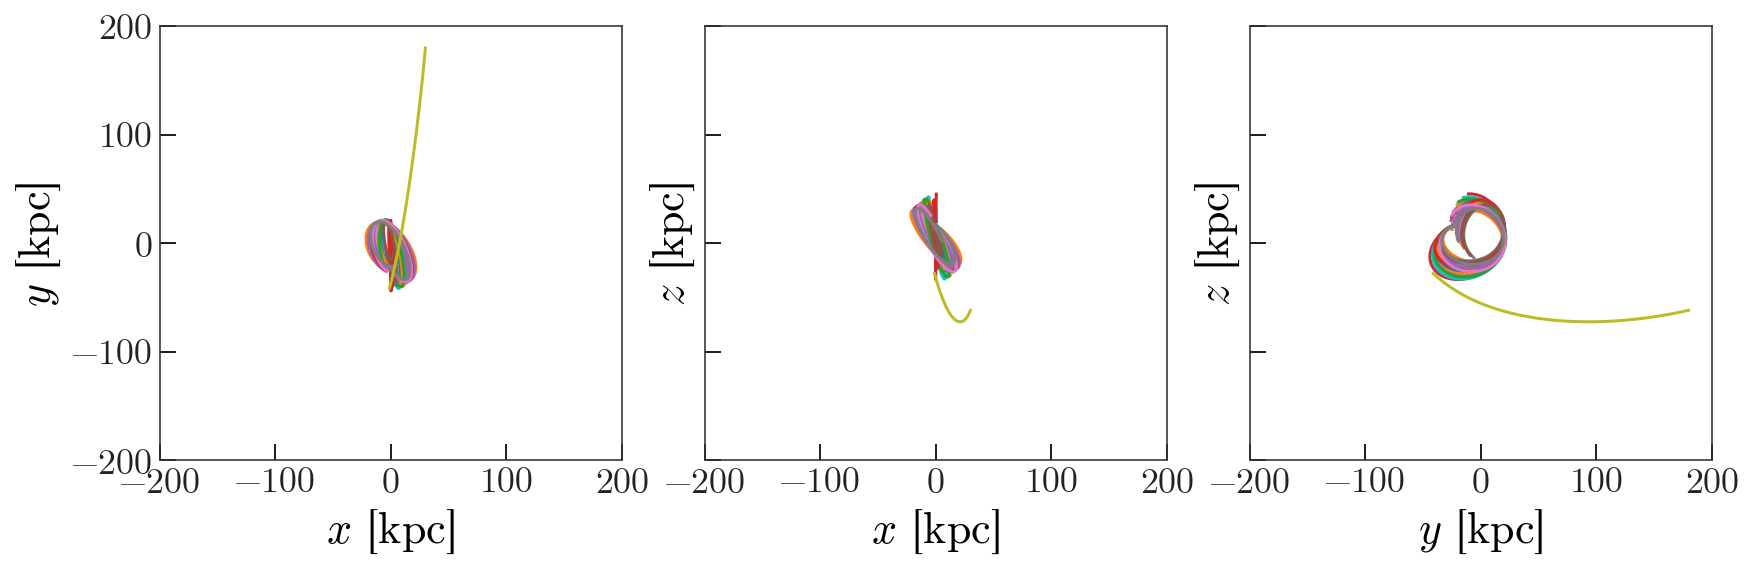

In [70]:
fig = cl_orbit.plot(auto_aspect=False, subplots_kwargs=dict(sharex=True, sharey=True))
_ = lmc_orbit.plot(auto_aspect=False, axes=fig.axes)

fig.axes[0].set_xlim(-200, 200)
fig.axes[0].set_ylim(-200, 200)

Compare longitude-distance to http://iopscience.iop.org/article/10.3847/1538-4357/835/2/285/meta Figure 16

In [140]:
cl_mag = cl_orbit.to_coord_frame(gc.MagellanicStream, galactocentric_frame=gc_frame)
lmc_mag = lmc_orbit_fut.to_coord_frame(gc.MagellanicStream, galactocentric_frame=gc_frame)

Text(0,0.5,'distance [kpc]')

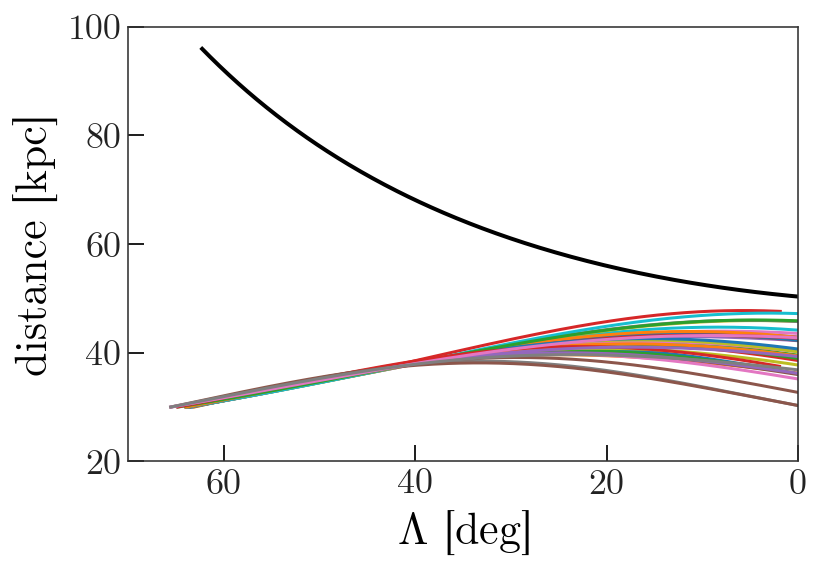

In [148]:
plt.plot(cl_mag.L.wrap_at(180*u.deg).degree,
         cl_mag.distance, marker='')

plt.plot(lmc_mag.L.wrap_at(180*u.deg).degree,
         lmc_mag.distance, 
         marker='', color='k', lw=2)

plt.xlim(70, 0)
plt.ylim(20, 100)
plt.xlabel(r'$\Lambda$ [deg]')
plt.ylabel(r'distance [kpc]')